In [1]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

DATA_PATH = './Datasets/Cards/'

Directorio actual: /tf/CNN-Cards


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, 
    Dropout, Dense, GlobalAveragePooling2D, Add, Activation
)
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Global variables
SIZE = 224
CLASSES = 53
EPOCHS = 20
PATIENCE_ES = 25
BATCH_SIZE = 64

path_models = 'Models'
path_results = 'Results'

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {tf.config.list_physical_devices("GPU")}')

2025-12-03 21:43:08.194524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-03 21:43:08.194600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-03 21:43:08.195706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Cargar datos con Data Augmentation agresiva

In [3]:
# Data augmentation agresiva para modelo custom
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.15,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=(0.9, 1.1),
    channel_shift_range=20
)

valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

train_dataset = train_generator.flow_from_directory(
    train_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataset = valid_generator.flow_from_directory(
    valid_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = test_generator.flow_from_directory(
    test_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7695 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## Evaluar modelo original

In [4]:
# Cargar modelo original
custom_original = tf.keras.models.load_model('Models/Custom_3.h5')
print('Arquitectura original:')
custom_original.summary()

Arquitectura original:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_6 (Dense)             (N

In [5]:
_, acc_original = custom_original.evaluate(test_dataset, verbose=0)
print(f'Accuracy original (Custom_3): {acc_original:.4f}')

Accuracy original (Custom_3): 0.7245


## Construir CNN mejorada

In [6]:
def conv_block(x, filters, kernel_size=3, dropout_rate=0.15):
    """Bloque convolucional con BatchNorm y Dropout"""
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)
    return x

def build_improved_cnn(input_shape=(224, 224, 3), num_classes=53):
    """Arquitectura CNN mejorada con 5 bloques convolucionales"""
    inputs = Input(shape=input_shape)
    
    # Bloque 1: 32 filtros
    x = conv_block(inputs, 32, dropout_rate=0.1)
    
    # Bloque 2: 64 filtros
    x = conv_block(x, 64, dropout_rate=0.2)
    
    # Bloque 3: 128 filtros
    x = conv_block(x, 128, dropout_rate=0.25)
    
    # Bloque 4: 256 filtros
    x = conv_block(x, 256, dropout_rate=0.3)
    
    # Bloque 5: 512 filtros
    x = conv_block(x, 512, dropout_rate=0.4)
    
    # Head de clasificacion
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

custom_improved = build_improved_cnn()
custom_improved.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                            

In [7]:
# Contar parametros
trainable_params = np.sum([np.prod(v.shape) for v in custom_improved.trainable_variables])
non_trainable_params = np.sum([np.prod(v.shape) for v in custom_improved.non_trainable_variables])
print(f'Parametros entrenables: {trainable_params:,}')
print(f'Parametros no entrenables: {non_trainable_params:,}')
print(f'Total: {trainable_params + non_trainable_params:,}')

Parametros entrenables: 4,887,253
Parametros no entrenables: 3,968
Total: 4,891,221


## Configurar entrenamiento

In [8]:
name = 'Custom_4'

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=PATIENCE_ES,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{name}',
    histogram_freq=1
)

callbacks_list = [checkpoint, early_stop, reduce_lr, tensorboard]

In [9]:
# Compilar
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

custom_improved.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Usamos label smoothing
    metrics=['accuracy']
)

In [17]:
# Entrenar
history = custom_improved.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/20
121/121 [==============================] - ETA: 0s - loss: 2.1615 - accuracy: 0.5414
Epoch 1: val_accuracy improved from 0.72075 to 0.73208, saving model to Models/Custom_4.h5

Epoch 1: val_accuracy improved from 0.72075 to 0.73208, saving model to Models/Custom_4.h5
121/121 [==============================] - 143s 1s/step - loss: 2.1615 - accuracy: 0.5414 - val_loss: 1.6406 - val_accuracy: 0.7321 - lr: 4.5000e-05
Epoch 2/20
121/121 [==============================] - 143s 1s/step - loss: 2.1615 - accuracy: 0.5414 - val_loss: 1.6406 - val_accuracy: 0.7321 - lr: 4.5000e-05
Epoch 2/20
121/121 [==============================] - ETA: 0s - loss: 2.1584 - accuracy: 0.5405
Epoch 2: val_accuracy did not improve from 0.73208

Epoch 2: val_accuracy did not improve from 0.73208
121/121 [==============================] - 75s 613ms/step - loss: 2.1584 - accuracy: 0.5405 - val_loss: 1.6937 - val_accuracy: 0.7208 - lr: 4.5000e-05
Epoch 3/20
121/121 [==============================] - 75s 613m

## Visualizar resultados

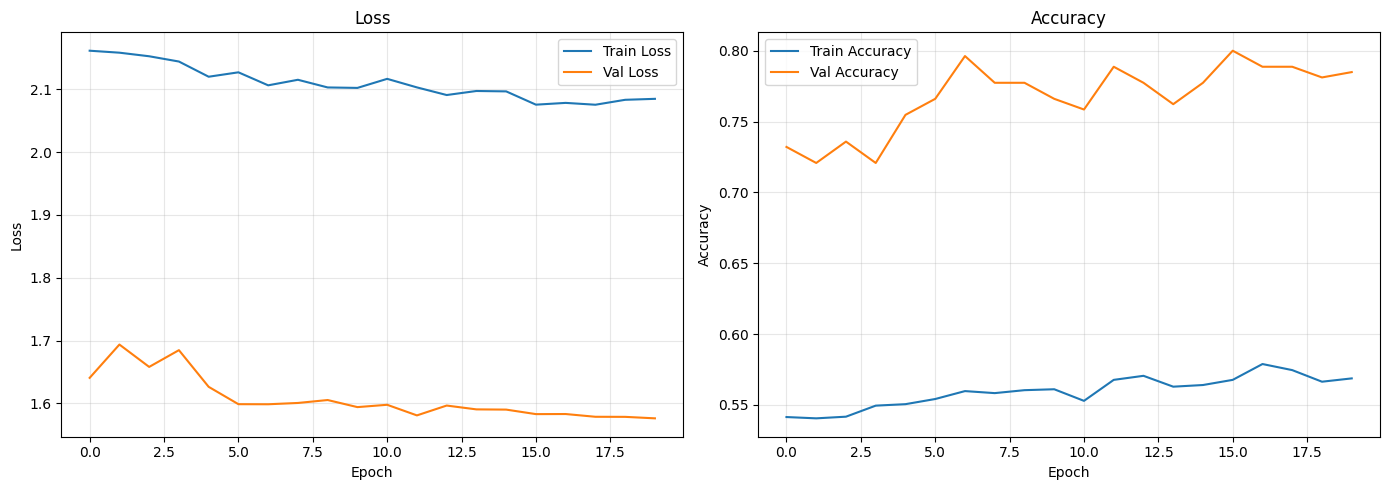

In [18]:
def plot_and_save(h, dir, name):
    history_df = pd.DataFrame(h.history)
    history_df['epoch'] = list(range(len(history_df)))
    history_df.to_csv(os.path.join(dir, name + '.csv'), header=True, index=False)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history_df['epoch'], history_df['loss'], label='Train Loss')
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_df['epoch'], history_df['accuracy'], label='Train Accuracy')
    axes[1].plot(history_df['epoch'], history_df['val_accuracy'], label='Val Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, name + '_curves.png'), dpi=150)
    plt.show()

plot_and_save(history, path_results, name)

## Evaluacion en Test Set

In [19]:
# Cargar mejor modelo
best_model = tf.keras.models.load_model(os.path.join(path_models, name + '.h5'))

# Evaluar
_, acc_improved = best_model.evaluate(test_dataset)

print(f'\n=== Comparacion de resultados ===')
print(f'Accuracy original (Custom_3): {acc_original:.4f}')
print(f'Accuracy mejorado (Custom_4): {acc_improved:.4f}')
print(f'Mejora: {(acc_improved - acc_original)*100:.2f}%')

5/5 [==============================] - 3s 519ms/step - loss: 1.6107 - accuracy: 0.7245

=== Comparacion de resultados ===
Accuracy original (Custom_3): 0.7245
Accuracy mejorado (Custom_4): 0.7245
Mejora: 0.00%
5/5 [==============================] - 3s 519ms/step - loss: 1.6107 - accuracy: 0.7245

=== Comparacion de resultados ===
Accuracy original (Custom_3): 0.7245
Accuracy mejorado (Custom_4): 0.7245
Mejora: 0.00%


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def show_report(model, dataframe):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    print(classification_report(true_text, pred_text))

def show_matrix(model, dataframe):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    cf = confusion_matrix(true_text, pred_text, labels=keys_array)
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(cf, annot=False, square=True, cbar=True,
                cmap=plt.cm.Blues, xticklabels=keys_array, yticklabels=keys_array, ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(f'Confusion Matrix - {name}')
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

show_report(best_model, test_dataset)

                   precision    recall  f1-score   support

     ace of clubs       0.67      0.80      0.73         5
  ace of diamonds       0.50      0.80      0.62         5
    ace of hearts       0.33      0.80      0.47         5
    ace of spades       0.28      1.00      0.43         5
   eight of clubs       0.71      1.00      0.83         5
eight of diamonds       0.62      1.00      0.77         5
  eight of hearts       0.40      0.40      0.40         5
  eight of spades       1.00      0.40      0.57         5
    five of clubs       0.75      0.60      0.67         5
 five of diamonds       1.00      0.80      0.89         5
   five of hearts       0.80      0.80      0.80         5
   five of spades       0.80      0.80      0.80         5
    four of clubs       1.00      0.80      0.89         5
 four of diamonds       1.00      0.80      0.89         5
   four of hearts       1.00      0.80      0.89         5
   four of spades       1.00      0.20      0.33       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


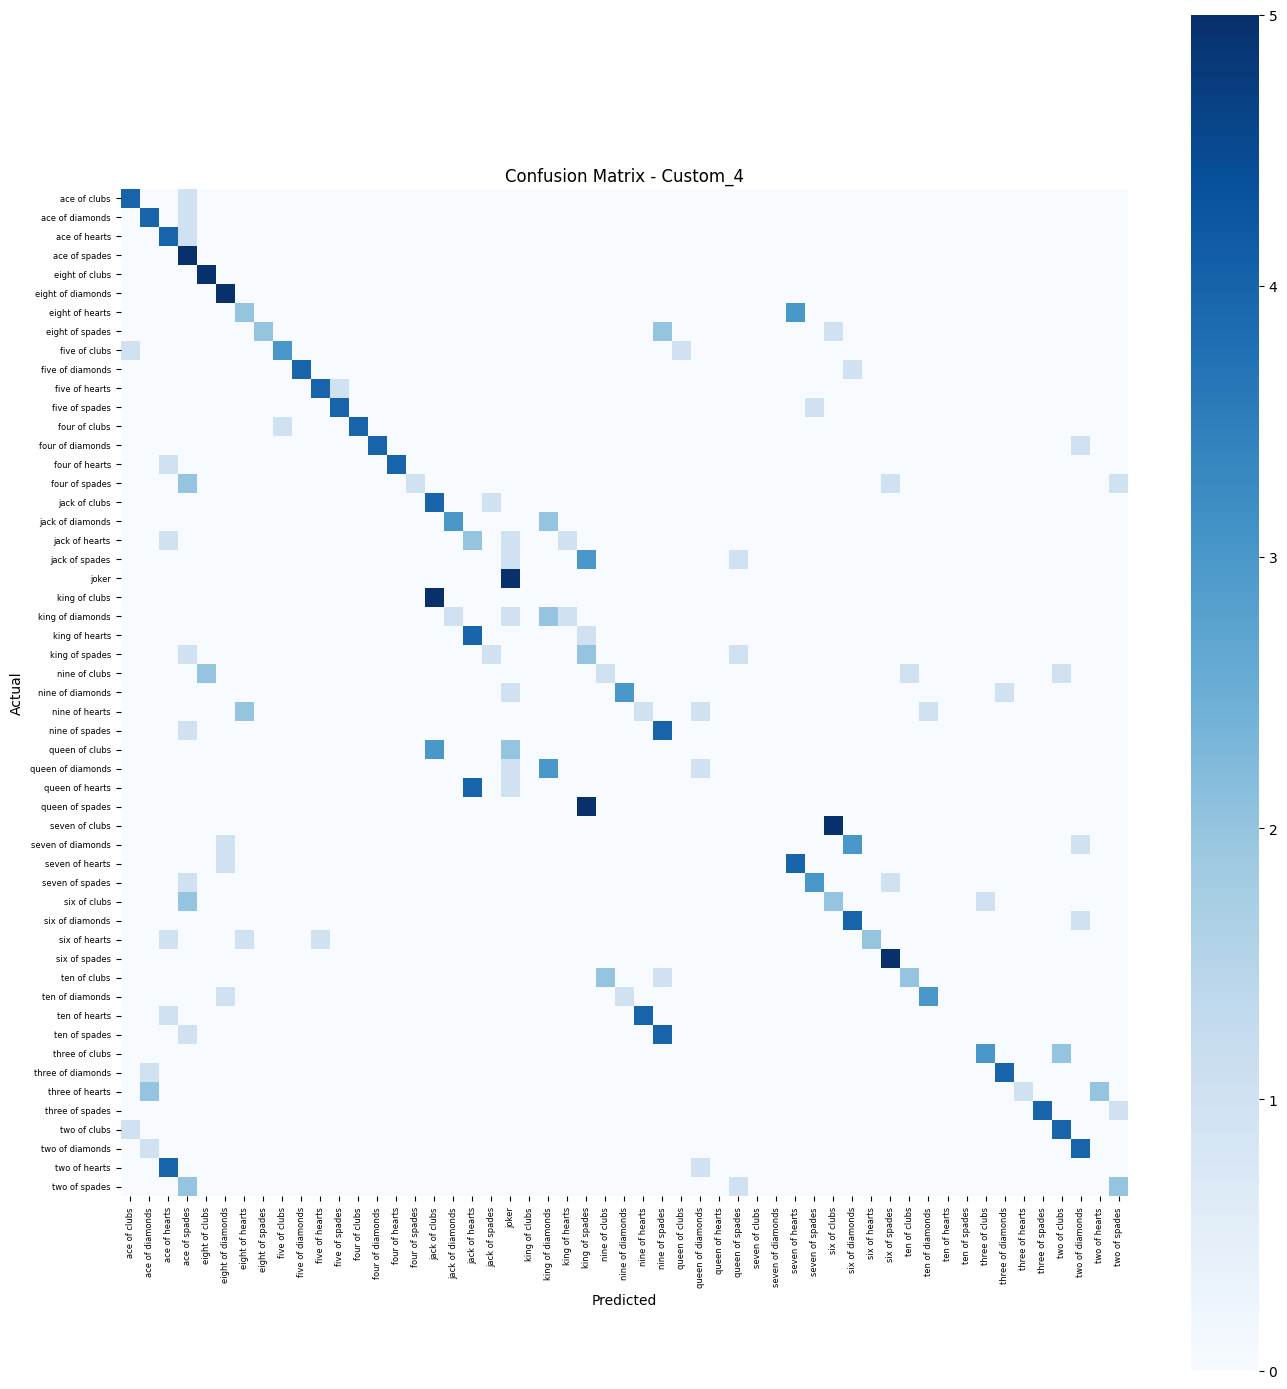

In [14]:
show_matrix(best_model, test_dataset)

## Alternativa: CNN con ResNet-style skip connections

In [15]:
def residual_block(x, filters):
    """Bloque residual simplificado"""
    shortcut = x
    
    x = Conv2D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    
    # Ajustar dimensiones si es necesario
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet_style_cnn(input_shape=(224, 224, 3), num_classes=53):
    """CNN con conexiones residuales"""
    inputs = Input(shape=input_shape)
    
    # Stem
    x = Conv2D(32, 7, strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Bloques residuales
    x = residual_block(x, 64)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.2)(x)
    
    x = residual_block(x, 128)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.25)(x)
    
    x = residual_block(x, 256)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.3)(x)
    
    x = residual_block(x, 512)
    x = Dropout(0.4)(x)
    
    # Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

# Descomentar para entrenar version con skip connections
custom_resnet = build_resnet_style_cnn()
custom_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 112, 112, 32)         4736      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 112, 112, 32)         128       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_10 (Activation)  (None, 112, 112, 32)         0         ['batch_normalization_10